In [1]:
import pandas as pd
import numpy as np
import pymysql as sql
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
import scipy.stats as stats

In [2]:
#Connecting to database to fetch the data
myconnection = sql.connect(host ="localhost",user = "root",password = "Mysql")

In [3]:
cur = myconnection.cursor()

In [4]:
cur.execute("use nutrition")

0

In [5]:
#Loading and Checking the Data
df = pd.read_sql("select * from nutrition.malnutrition",con = myconnection)
df.head()

C:\Users\DURGA PRASATH\AppData\Local\Temp\ipykernel_17124\3782865023.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("select * from nutrition.malnutrition",con = myconnection)


,region,gender,year,lower_bound,upper_bound,mean_estimate,country,age_group,ci_width,malnutrition
0,Americas,Male,2013,0.94316,1.89881,1.36614,Argentina,Adult,0.95565,Low
1,Africa,Female,2021,3.97204,8.07702,5.79511,Gabon,Adult,4.10498,Low
2,Western Pacific,Both,2017,2.42823,3.84215,3.09065,Mongolia,Adult,1.41392,Low
3,Africa,Female,2016,6.65567,10.25312,8.37172,Sierra Leone,Adult,3.59745,Low
4,None,Both,2021,12.24232,14.44287,13.33635,South-East Asia Region,Adult,2.20055,Moderate


In [6]:
#Dimenision
df.shape

(27720, 10)

    Rows = 27720
    Columns = 10

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27720 entries, 0 to 27719
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   region         26268 non-null  object 
 1   gender         27720 non-null  object 
 2   year           27720 non-null  object 
 3   lower_bound    27720 non-null  float64
 4   upper_bound    27720 non-null  float64
 5   mean_estimate  27720 non-null  float64
 6   country        27720 non-null  object 
 7   age_group      27720 non-null  object 
 8   ci_width       27720 non-null  float64
 9   malnutrition   27720 non-null  object 
dtypes: float64(4), object(6)
memory usage: 2.1+ MB


## Observation
    There are 4 columns with float datatype and 6 columns with object datatype
    region has missing values.

In [10]:
# Converting the datatype of year to int
df['year'] = df['year'].apply(int)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27720 entries, 0 to 27719
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   region         26268 non-null  object 
 1   gender         27720 non-null  object 
 2   year           27720 non-null  int64  
 3   lower_bound    27720 non-null  float64
 4   upper_bound    27720 non-null  float64
 5   mean_estimate  27720 non-null  float64
 6   country        27720 non-null  object 
 7   age_group      27720 non-null  object 
 8   ci_width       27720 non-null  float64
 9   malnutrition   27720 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 2.1+ MB


## Observation After change of year datatype
    There are 1 column with int datatype, 4 columns with float datatype and 6 columns with object datatype
    Still region has missing values.

In [13]:
# Basic Summary Statistics
df.describe()

,year,lower_bound,upper_bound,mean_estimate,ci_width
count,27720.000000,27720.000000,27720.000000,27720.000000,27720.000000
mean,2017.000000,3.397094,8.147889,5.354451,4.750795
std,3.162335,3.908061,6.443692,4.811220,4.257684
min,2012.000000,0.023700,0.354830,0.175310,0.166680
25%,2014.000000,1.053662,3.143305,2.039283,1.603222
50%,2017.000000,1.907975,6.095555,3.597790,3.351095
75%,2020.000000,4.186443,11.526302,7.335245,6.530875
max,2022.000000,31.365400,43.680290,35.894112,26.701740


## Observation
    1. Total of 27720 data entries present in dataset
    2. Mean of the each numrical column is displayed
    3. Standard deviation of the column is displayed
    4. Min and Max value of the column is displayed
    5. Percentile at 25%, 50%, and 75% are displayed

In [15]:
# Summary of dataset with objects included
df.describe(include='object')

,region,gender,country,age_group,malnutrition
count,26268,27720,27720,27720,27720
unique,6,3,210,2,3
top,Europe,Male,Argentina,Child,Low
freq,6864,9240,132,20790,23660


In [16]:
# Finding the number of duplicate values
df.duplicated().sum()

0

In [17]:
# Finding duplicate values in each row if present
df[df.duplicated()]

,region,gender,year,lower_bound,upper_bound,mean_estimate,country,age_group,ci_width,malnutrition


### No Dulicate values found in dataset

In [20]:
# Finding the number if null value
df.isnull().sum()

region           1452
gender              0
year                0
lower_bound         0
upper_bound         0
mean_estimate       0
country             0
age_group           0
ci_width            0
malnutrition        0
dtype: int64

### We have 0 missing values in the 9 columns except the region column which has 1452 missing values

In [23]:
# Find the precentage of the missing data
(df.isnull().sum() / len(df)) * 100

region           5.238095
gender           0.000000
year             0.000000
lower_bound      0.000000
upper_bound      0.000000
mean_estimate    0.000000
country          0.000000
age_group        0.000000
ci_width         0.000000
malnutrition     0.000000
dtype: float64

### We have 5.238% of missing values in region column

In [26]:
# Impute missing 'region' values
# Create a mapping from country to region using non-missing data
country_to_region = df.dropna(subset=['region']).set_index('country')['region'].to_dict()

In [27]:
# Function for the 
def matchRegionToCountry(country_region):
    country = country_region[0]
    region = country_region[1]
    if pd.isna(region):
        return country_to_region.get(country)  
    else:
        return region

In [28]:
# Fill missing 'region' values using the mapping
df['region'] = df[['country','region']].apply(matchRegionToCountry, axis=1)

# Fill remaining missing values in 'region' with 'Unknown' , if no value match in mapping
df['region'].fillna('Unknown', inplace=True)

# Verify missing values after imputation
df.isnull().sum()

C:\Users\DURGA PRASATH\AppData\Local\Temp\ipykernel_17124\3225903115.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  country = country_region[0]
C:\Users\DURGA PRASATH\AppData\Local\Temp\ipykernel_17124\3225903115.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region = country_region[1]
C:\Users\DURGA PRASATH\AppData\Local\Temp\ipykernel_17124\3468119205.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we ar

region           0
gender           0
year             0
lower_bound      0
upper_bound      0
mean_estimate    0
country          0
age_group        0
ci_width         0
malnutrition     0
dtype: int64

## Observation after the imputation
    We have 0 missing values

In [30]:
df.to_csv("malnurtition_preprocessed_dataset.csv")

In [31]:
# Getting the unique values of each column in dataset
df.nunique()

region               7
gender               3
year                11
lower_bound      27078
upper_bound      27469
mean_estimate    27319
country            210
age_group            2
ci_width         27276
malnutrition         3
dtype: int64

In [32]:
# Check counts for object columns
print("Value counts for 'region':")
print(df['region'].value_counts(dropna=False)) # Include NaN in counts
print("\n")

print("Value counts for 'gender':")
print(df['gender'].value_counts())
print("\n")

print("Value counts for 'age_group':")
print(df['age_group'].value_counts())
print("\n")

print("Value counts for 'malnutrition':")
print(df['malnutrition'].value_counts())
print("\n")

print("\nValue counts for 'country' (top 25):")
print(df['country'].value_counts().head(25))
print("\n")

print("Value counts for 'year':")
print(df['year'].sort_values().value_counts())
print("\n")

# Check the range of the 'year' column
print(f"Year range: {df['year'].min()} - {df['year'].max()}")
print("\n")

Value counts for 'region':
region
Europe                   6864
Africa                   6204
Americas                 4884
Western Pacific          3960
Eastern Mediterranean    2904
Unknown                  1452
South-East Asia          1452
Name: count, dtype: int64


Value counts for 'gender':
gender
Male      9240
Female    9240
Both      9240
Name: count, dtype: int64


Value counts for 'age_group':
age_group
Child    20790
Adult     6930
Name: count, dtype: int64


Value counts for 'malnutrition':
malnutrition
Low         23660
Moderate     3558
High          502
Name: count, dtype: int64



Value counts for 'country' (top 25):
country
Argentina              132
Spain                  132
Türkiye                132
Niger                  132
Europe                 132
Tokelau                132
Mauritius              132
Upper Middle Income    132
Jordan                 132
Madagascar             132
Viet Nam               132
Liberia                132
Uganda                 13

In [33]:
# Displays column name
df.columns

Index(['region', 'gender', 'year', 'lower_bound', 'upper_bound',
       'mean_estimate', 'country', 'age_group', 'ci_width', 'malnutrition'],
      dtype='object')

In [34]:
#Differentiating the feature into numeric and categorical
numeric_features = ['lower_bound', 'upper_bound', 'mean_estimate', 'ci_width', 'year']
categorical_features = ['region', 'gender', 'age_group', 'malnutrition']

In [35]:
# print columns
print(f'We have {len(numeric_features)} numerical features : {numeric_features}')
print(f'We have {len(categorical_features)} categorical features : {categorical_features}')

We have 5 numerical features : ['lower_bound', 'upper_bound', 'mean_estimate', 'ci_width', 'year']
We have 4 categorical features : ['region', 'gender', 'age_group', 'malnutrition']


In [36]:
# Checking the skewness of the numerical columns
print(f'skewness_of_lower_bound : {skew(df['lower_bound'])}')
print(f'skewness_of_upper_bound : {skew(df['upper_bound'])}')
print(f'skewness_of_mean_estimate : {skew(df['mean_estimate'])}')
print(f'skewness_of_ci_width : {skew(df['ci_width'])}')
print(f'skewness_of_year : {skew(df['year'])}')

skewness_of_lower_bound : 2.4041669346379546
skewness_of_upper_bound : 1.3015646685122257
skewness_of_mean_estimate : 1.798929240224807
skewness_of_ci_width : 1.5179352604262741
skewness_of_year : 0.0


## Univariate Analysis

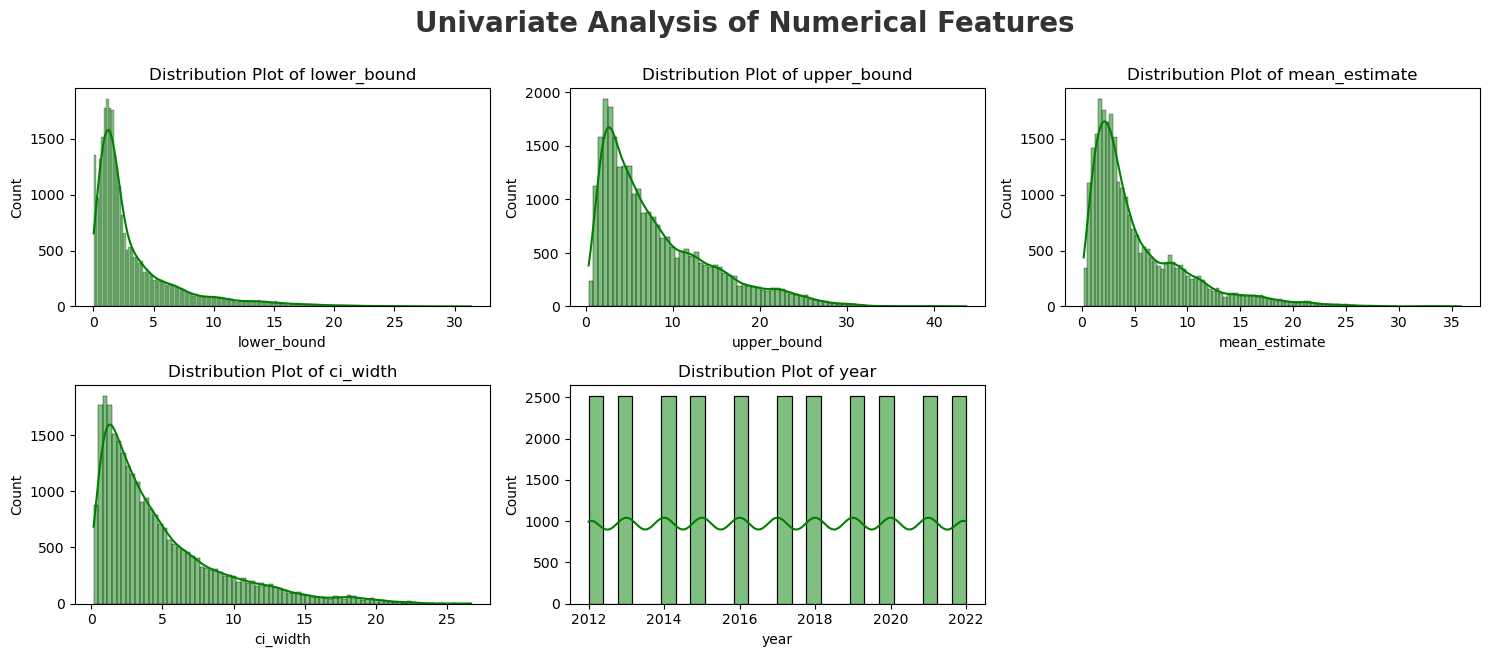

In [38]:
# Histo plot of Numerical columns
plt.figure(figsize=(15, 15))
plt.suptitle('Univariate Analysis of Numerical Features', fontsize=20, fontweight='bold', alpha=0.8, y=1.)
for i in range(0, len(numeric_features)):
    plt.subplot(5, 3, i+1)
    sns.histplot(x=df[numeric_features[i]],kde=True, color='g')
    plt.xlabel(numeric_features[i])
    plt.title(f'Distribution Plot of {numeric_features[i]}')
plt.tight_layout()
plt.show()

# Obervation
    1. lower_bound, upper_bound, mean_estimate and ci_width distributions are positive skewed or right skewed and it is leptoKurtosis.
    2. lower_bound, upper_bound, mean_estimate and ci_width distributions the central tendency value like  be Mean > Median > Mode.
    3. The year column show the uniform distribution of data.
    4. Year column has no skewness since the distribution is uniform and Mean = Median = Mode.
    5. Most of the value of lower_bound are to the left side of ploting which shows that data points are to the minimum.
    6. Most of the value of upper_bound are to the left side of ploting which shows that data points are minimum.
    7. Most of the value of mean_estimate are to the left side of ploting which shows that data points are minimum.
    8. Most of the value of ci_width are to the left side of ploting which shows that data points are minimum.
    5. On each year the data entries points are equal.

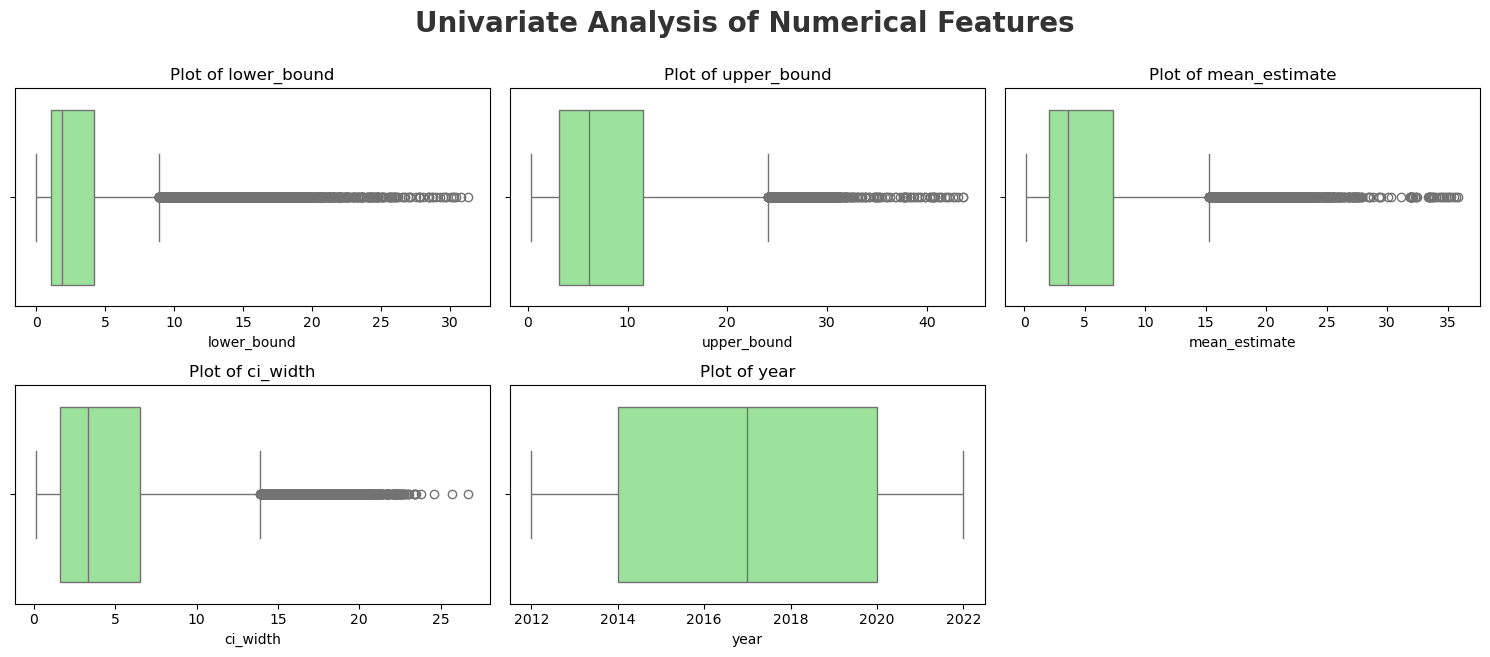

In [40]:
# Box plot of Numerical columns to see outlier
plt.figure(figsize=(15, 15))
plt.suptitle('Univariate Analysis of Numerical Features', fontsize=20, fontweight='bold', alpha=0.8, y=1.)
for i,col in enumerate(numeric_features):
    plt.subplot(5, 3, i+1)
    sns.boxplot(x=df[col], color='lightgreen')
    plt.xlabel(numeric_features[i])
    plt.title(f'Plot of {numeric_features[i]}')
plt.tight_layout()
plt.show()

# Obervation
    1) Median line of lower_bound, upper_bound, mean_estimate and ci_width are towards the left side of the plot.
    2) We can confirm from the boxplot that lower_bound, upper_bound, mean_estimate and ci_width are positive skewed(right skewed).
    3) Year has symmetric distribution and Median line is almost in mid of the distribution plot.
    4) lower_bound, upper_bound, mean_estimate and ci_width columns have many outlier data point 

In [42]:
#Function to get the number of outlier in the columns
def count_outliers_iqr(data):
    q1 = np.quantile(data, 0.25)
    q3 = np.quantile(data, 0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return len(outliers)

In [43]:
#Seeing the number of outlier in columns
print(f'Number of outlier in lower_bound : {count_outliers_iqr(df['lower_bound'])}')
print(f'Number of outlier in upper_bound : {count_outliers_iqr(df['upper_bound'])}')
print(f'Number of outlier in mean_estimate : {count_outliers_iqr(df['mean_estimate'])}')
print(f'Number of outlier in ci_width : {count_outliers_iqr(df['ci_width'])}')

Number of outlier in lower_bound : 2497
Number of outlier in upper_bound : 761
Number of outlier in mean_estimate : 1509
Number of outlier in ci_width : 1314


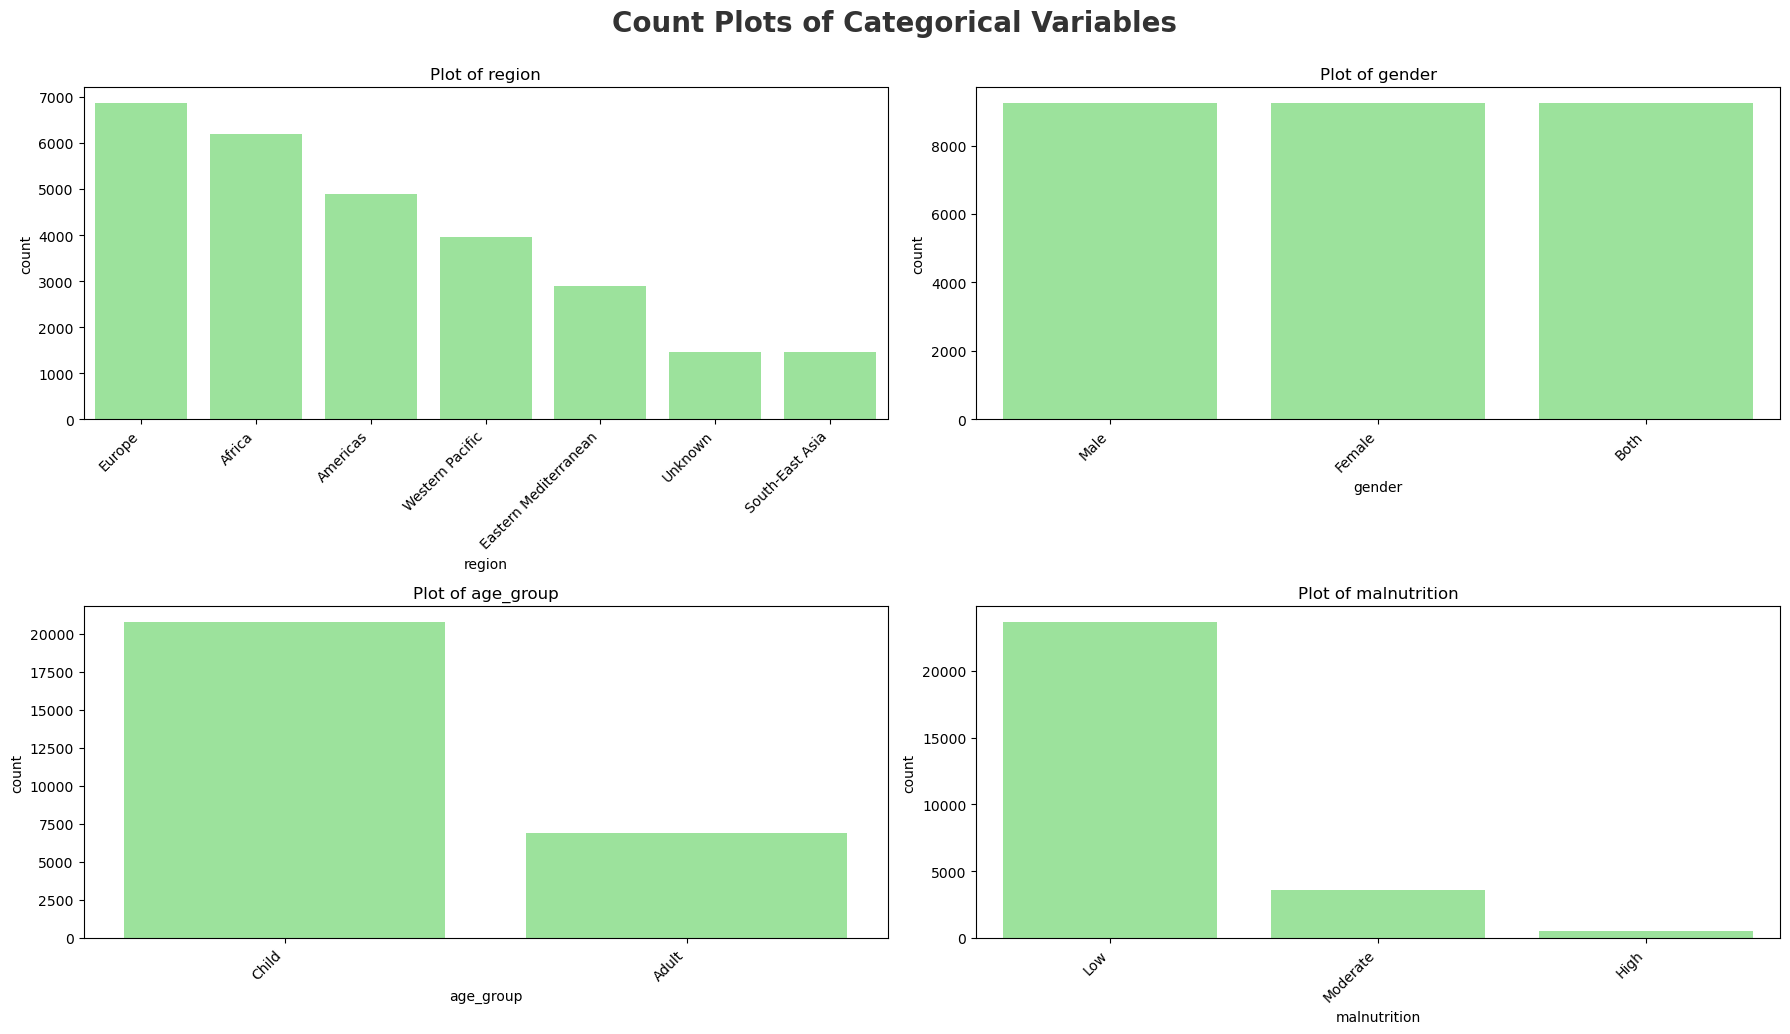

In [44]:
# Histo plot for Categorical columns
plt.figure(figsize=(18, 25))
for i, col in enumerate(categorical_features):
    plt.subplot(5, 2, i + 1)
    sns.countplot(x=col, data=df, color='lightgreen',order = df[col].value_counts().index)
    plt.title(f'Plot of {col}')
    plt.xticks(rotation=45, ha='right')
plt.suptitle('Count Plots of Categorical Variables',  fontsize=20, fontweight='bold', alpha=0.8, y=1.)
plt.tight_layout()
plt.show()

# Observations of the categorical variables:

## region:

    1) 'Europe', 'Africa', and 'Americas' are the regions with the highest number of entries in the dataset.
    2) 'Western Pacific', 'Eastern Mediterranean' have less number of entries then 'Europe', 'Africa', and 'Americas'.
    3) 'South-East Asia' and 'Unknown' category (imputed values) seems similar number of entries.

## gender:

    1) The counts for 'Male', 'Female', and 'Both' genders are almost perfectly equal. 
    2) This indicates a balanced representation of gender categories in the dataset.

## age_group:

    1) The 'Child' age group has a higher count compared to the 'Adult' age group.
    2) Since child count is higher, the data of childer's malnutrition data is more then the adult's in dataset.

## malnutrition:

    1) 'Low' malnutrition category is higher, compare to 'High' and 'Moderate' categories combined. Which shows in dataset of 'low' malnutrition entries are higher.
    2) 'Moderate' malnutrition has a higher count than 'High' malnutrition.
    3) 'High' malnutrition has a leastest count.

In [46]:
# Bivariate Analysis

# 1. Numerical vs. Numerical
# Correlation Matrix and Heatmap
numerical_cols = ['lower_bound', 'upper_bound', 'mean_estimate', 'ci_width', 'year']
correlation_matrix = df[numerical_cols].corr()
print(correlation_matrix)

               lower_bound  upper_bound  mean_estimate  ci_width      year
lower_bound       1.000000     0.767725       0.940908  0.244011 -0.077694
upper_bound       0.767725     1.000000       0.937148  0.808744  0.036168
mean_estimate     0.940908     0.937148       1.000000  0.554660 -0.023190
ci_width          0.244011     0.808744       0.554660  1.000000  0.126052
year             -0.077694     0.036168      -0.023190  0.126052  1.000000


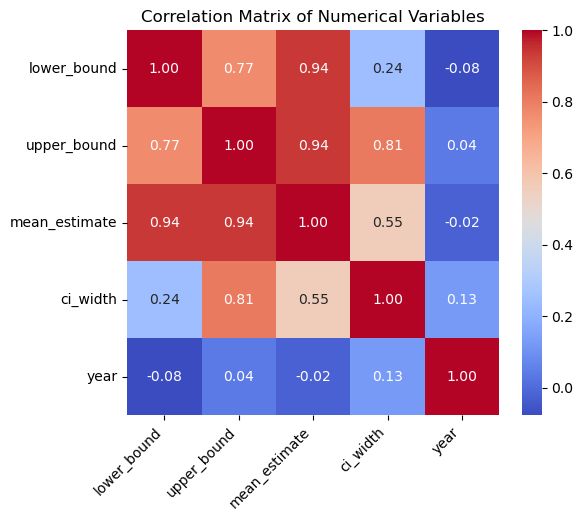

In [47]:
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.xticks(rotation=45, ha='right')
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

# Observations from the correlation matrix heatmap of the numerical variables:

## Strong Positive Correlations (Near 1.0):

    mean_estimate is highly correlated with both lower_bound (0.94) and upper_bound (0.94). This is expected, as mean_estimate is the central value between lower_bound and upper_bound, and these three variables describe the same estimated range.
    ci_width and upper_bound also show a strong positive correlation with each other (0.81).
    lower_bound and upper_bound have moderate positive correlation with each other (0.77)

## Moderate Positive Correlation (Around mid 0.5):

    ci_width (confidence interval width) shows a moderate positive correlation with mean_estimate (0.55). 
    
## Weak Positive Correlations (Near 0):

    year has a weak positive correlation with ci_width (0.13), upper_bound (0.04), and mean_estimate (0.11).
    
## Negative Correlations:

    lower_bound (-0.08) and mean_estimate (-0.02) shows a very weak and negative correlation with year.

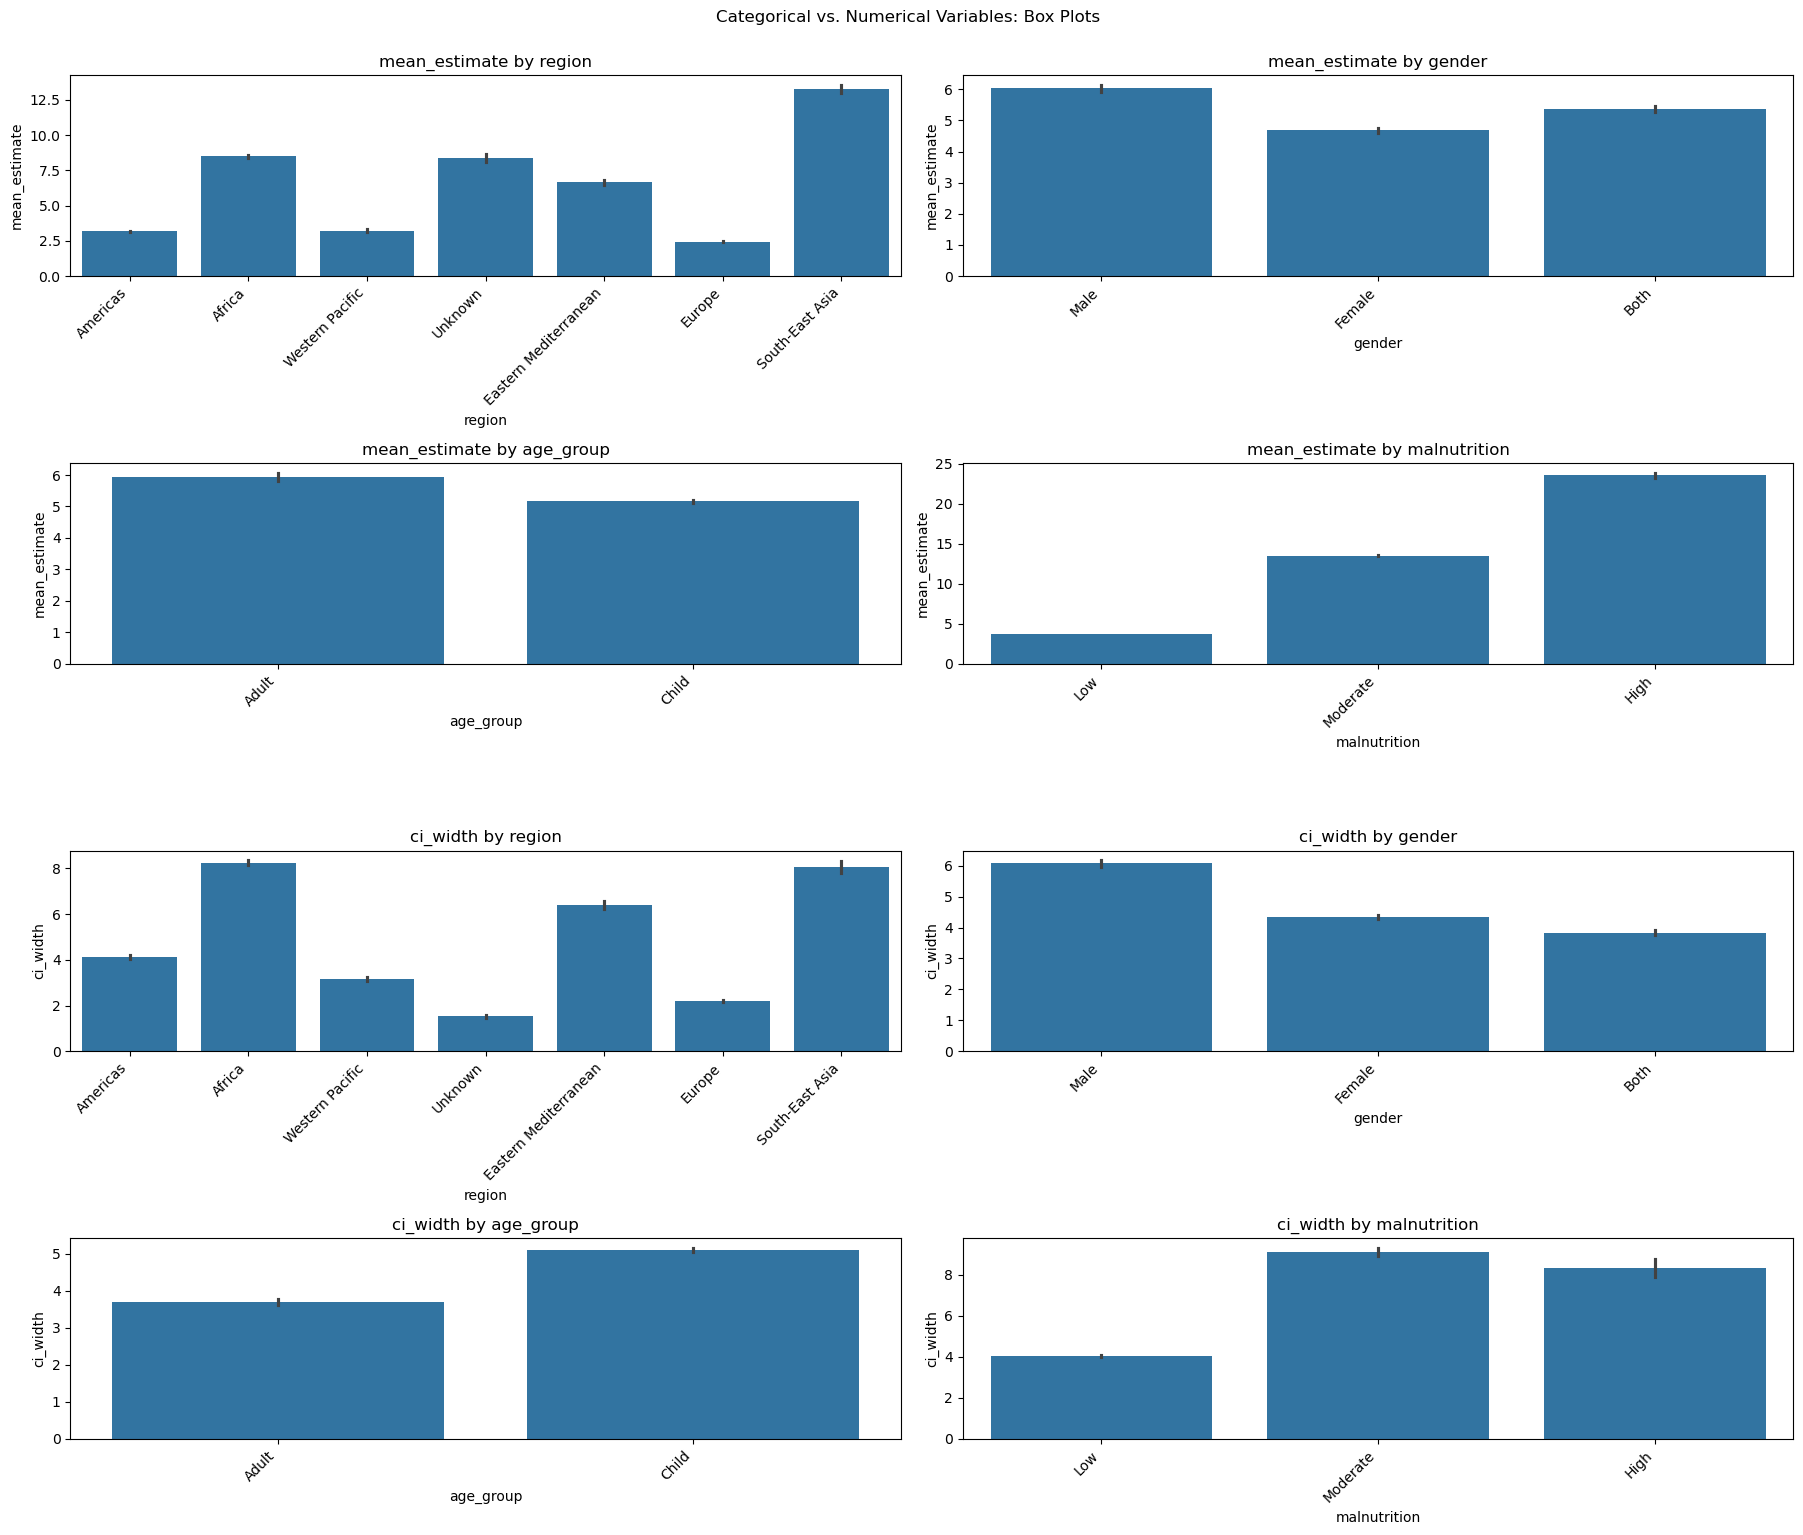

In [49]:
# 2. Categorical vs. Numerical
# Box plots of mean_estimate and ci_width across categorical variables
categorical_num_pairs = [
    ('region', 'mean_estimate'),
    ('gender', 'mean_estimate'),
    ('age_group', 'mean_estimate'),
    ('malnutrition', 'mean_estimate'),
    ('region', 'ci_width'),
    ('gender', 'ci_width'),
    ('age_group', 'ci_width'),
    ('malnutrition', 'ci_width')
]

plt.figure(figsize=(18, 15))
for i, (cat_col, num_col) in enumerate(categorical_num_pairs):
    plt.subplot(4, 2, i + 1)
    sns.barplot(x=cat_col, y=num_col, data=df)
    plt.title(f'{num_col} by {cat_col}')
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.suptitle('Categorical vs. Numerical Variables: Box Plots', y=1.02)
plt.show()

# Observations from the bar plots 
## mean_estimate and ci_width across different categorical variables:

    1.mean_estimate and region:
        'South-East Asia' regions show the highest mean_estimate values, indicating high malnutrition percentages in these regions.
        'Eastern mediterranean' and 'Africa' have moderate mean_estimate values .
        'Americas', 'Western Pacific' and 'Europe' have low mean_estimate values.
        The 'Unknown' region has an mean_estimate somewhere in the middle, which is representing countries whose regions were initially missing.

    2.mean_estimate and gender:
        Mean_estimate along the gender varies little towards each gender.
        'Male' gender have the higher mean_estimate then other gender.
        'Female' gender has the least mean_estimate.
        'Both' gender inbetween the 'male' and 'female' gender.

    3.mean_estimate and age_group:
        The 'Adult' age group has a significantly higher mean_estimate compared to the 'Child' age group. This clearly indicates that malnutrition percentages much higher in adults than in children.

    4.mean_estimate and malnutrition level:
        The mean_estimate values are clearly separated by the malnutrition categories: 'High' has the highest, 'Moderate' is in the middle, and 'Low' has the lowest mean_estimate.

    5.ci_width and region:
        'South-East Asia' and 'Africa' show high level in ci_width values.
        'Eastern mediterranean' have moderately lesser level then 'South-East Asia' and 'Africa'.
        'America' and 'Western Pacific' have almost similar ci_width values.
        'Unknown' and 'Europe' have the least ci_width values.

    6.ci_width by gender:
        The ci_width values are high in "Male','Female' is slight less then 'Male' and 'Both' in slight less then 'Female'.

    7.ci_width by age_group:
        The 'Adult' age group has a noticeably higher ci_width than the 'Child' age group.

    8.ci_width by malnutrition:
        'Moderate' has the highest, 'High' is in the middle, and 'Low' has the lowest ci_width.

In [53]:
# 3. Categorical vs. Categorical
# Crosstabulations for key categorical relationships
print("\nCrosstab: Region vs. Malnutrition")
print(pd.crosstab(df['region'], df['malnutrition']))

print("\nCrosstab: Gender vs. Malnutrition")
print(pd.crosstab(df['gender'], df['malnutrition']))

print("\nCrosstab: Age Group vs. Malnutrition")
print(pd.crosstab(df['age_group'], df['malnutrition']))


Crosstab: Region vs. Malnutrition
malnutrition           High   Low  Moderate
region                                     
Africa                  183  4484      1537
Americas                  0  4818        66
Eastern Mediterranean    49  2312       543
Europe                    0  6857         7
South-East Asia         211   522       719
Unknown                  58   946       448
Western Pacific           1  3721       238

Crosstab: Gender vs. Malnutrition
malnutrition  High   Low  Moderate
gender                            
Both           127  7917      1196
Female          82  8317       841
Male           293  7426      1521

Crosstab: Age Group vs. Malnutrition
malnutrition  High    Low  Moderate
age_group                          
Adult          168   5523      1239
Child          334  18137      2319


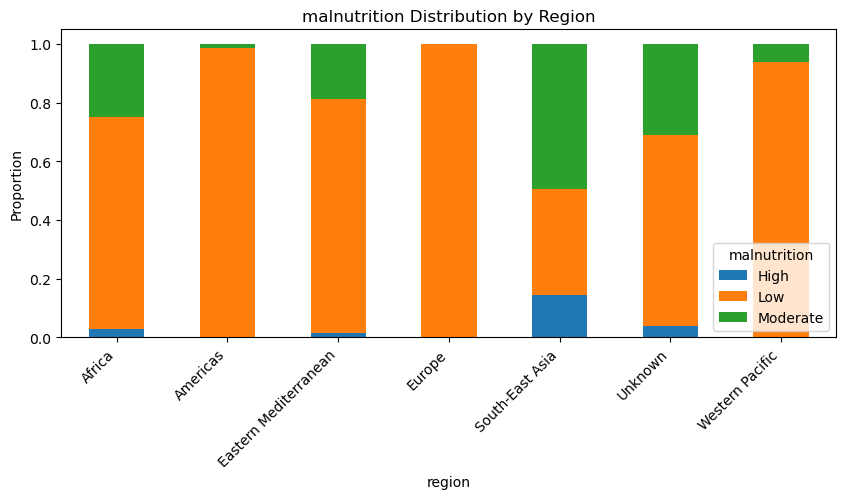

In [54]:
# Stacked Bar Charts for categorical relationships
# Region vs. malnutrition
df_region_malnutrition = pd.crosstab(df['region'], df['malnutrition'], normalize='index')
df_region_malnutrition.plot(kind='bar', stacked=True, figsize=(10, 4))
plt.title('Malnutrition Distribution by Region')
plt.ylabel('Proportion')
plt.xticks(rotation=45, ha='right')
plt.show()


## Observations from the stacked bar 'malnutrition Distribution by Region':

    Across 'Americas', 'Africa', 'Eastern mediterranean', 'Europe', 'Unknown' and 'Western Pacific' regions, the 'Low' malnutrition category as the largest proportion.

    'South-East Asia' show a visibly larger proportion of 'Moderate' and 'High' malnutrition compared to other regions.

    'Africa' and 'Unknown' also have 'High' and 'Moderate' malnutrition, but their proportions are smaller than 'South-East Asia'.

    'Americas' and 'Western Pacific' has a very small proportion 'Moderate' malnutrition, with 'Low' almost the entire bar.

    'Europe' region show has only the 'Low' malnutrition.

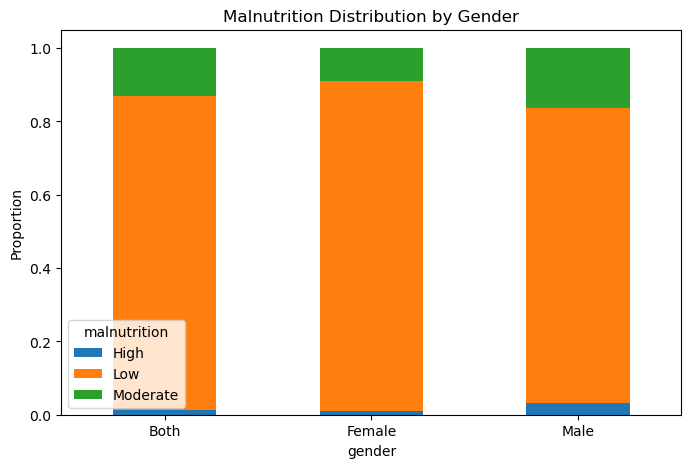

In [56]:
# Gender vs. malnutrition
df_gender_malnutrition = pd.crosstab(df['gender'], df['malnutrition'], normalize='index')
df_gender_malnutrition.plot(kind='bar', stacked=True, figsize=(8, 5))
plt.title('Malnutrition Distribution by Gender')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.show()

## Observations from the stacked bar chart of 'Malnutrition Distribution by Gender':

    For all gender categories ('Male', 'Female', and 'Both'), the 'Low' malnutrition category is majorly observed.

    'Female' and 'Both' categories have almost a similar proportion of 'high' malnutrition with 'Male' being bit more then other two gender.

    Categories of the gender shows that malnutrition is not only relating towards one or two gender categories but all gender have the 'low' malnutrition and 'Moderate' malnutrition.

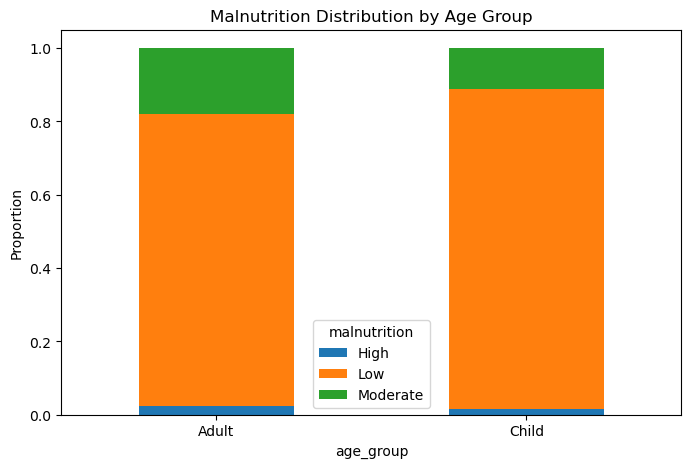

In [58]:
# Age Group vs. Malnutrition
df_agegroup_malnutrition = pd.crosstab(df['age_group'], df['malnutrition'], normalize='index')
df_agegroup_malnutrition.plot(kind='bar', stacked=True, figsize=(8, 5))
plt.title('Malnutrition Distribution by Age Group')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.show()

## Observations from the stacked bar chart of 'Malnutrition Distribution by Age Group':

    This plot reveals a very strong and clear relationship between age_group and the distribution of malnutrition categories.

    'Child' age_group is majorly of 'Low' malnutrition level.
    
    'Moderate' malnutrition is high in Adult then Children.
    
    The proportions of 'High' malnutrition in both Adult and Children are extremely small.

# Summary of the EDA's of malnutrition dataset

The EDA revealed a dataset rich in demographic(age_group) and geographical(region) information related to malnutrition

    The majority of observations fall into the 'Low' malnutrition category. However, the 'High' and 'Moderate' categories are comparatively  smaller, represent crucial areas for intervention and study. This imbalance is a primary concern for predictive modeling.

    Age is the demographic factor:

        Adults show significantly higher malnutrition estimates and a much greater proportion of 'High' and 'Moderate' malnutrition compared to 'Children'. 
        This suggests that interventions and public health strategies related to malnutrition should strongly prioritize the adult population.

    Regional is the geographical factor:

        'South-East Asia' regions exhibit the highest malnutrition estimates and the largest proportions of 'High' and 'Moderate' malnutrition.These region likely require attention for malnutrition prevention and management.
        Europe stands out with almost 'Low' malnutrition observations.

    Gender Shows Minimal Impact on malnutrition: 
        Across the all three categories of gender, the proportional distribution of 'Male' gender categories have 'High' and 'Moderate' malnutrition more compare to 'Female', and 'Both' genders. 
        Gender 'Both' have comparitively higher 'High' and 'Moderate' then 'Female' gender.

    Numerical Estimates are Skewed with Outliers:
        The mean_estimate, lower_bound, upper_bound, and ci_width columns are all right-skewed(positively skewed) and contain significant outliers at the higher end. Proper handling of these outliers and data transformation will be essential for robust statistical modeling.

    Data Quality is Generally Good (Post-Imputation): 
        After imputing the missing values in the region column, the dataset is clean with no duplicates.

    In essence, this EDA highlights age and region as the primary role on malnutrition patterns in this dataset, while gender appears to play a minor role. 

In [62]:
# Apply log transformation
df['lower_bound_transformed'] = np.log(df['lower_bound'])
df['upper_bound_transformed'] = np.log(df['upper_bound'])
df['mean_estimate_transformed'] = np.log(df['mean_estimate'])
df['ci_width_transformed'] = np.log(df['ci_width'])

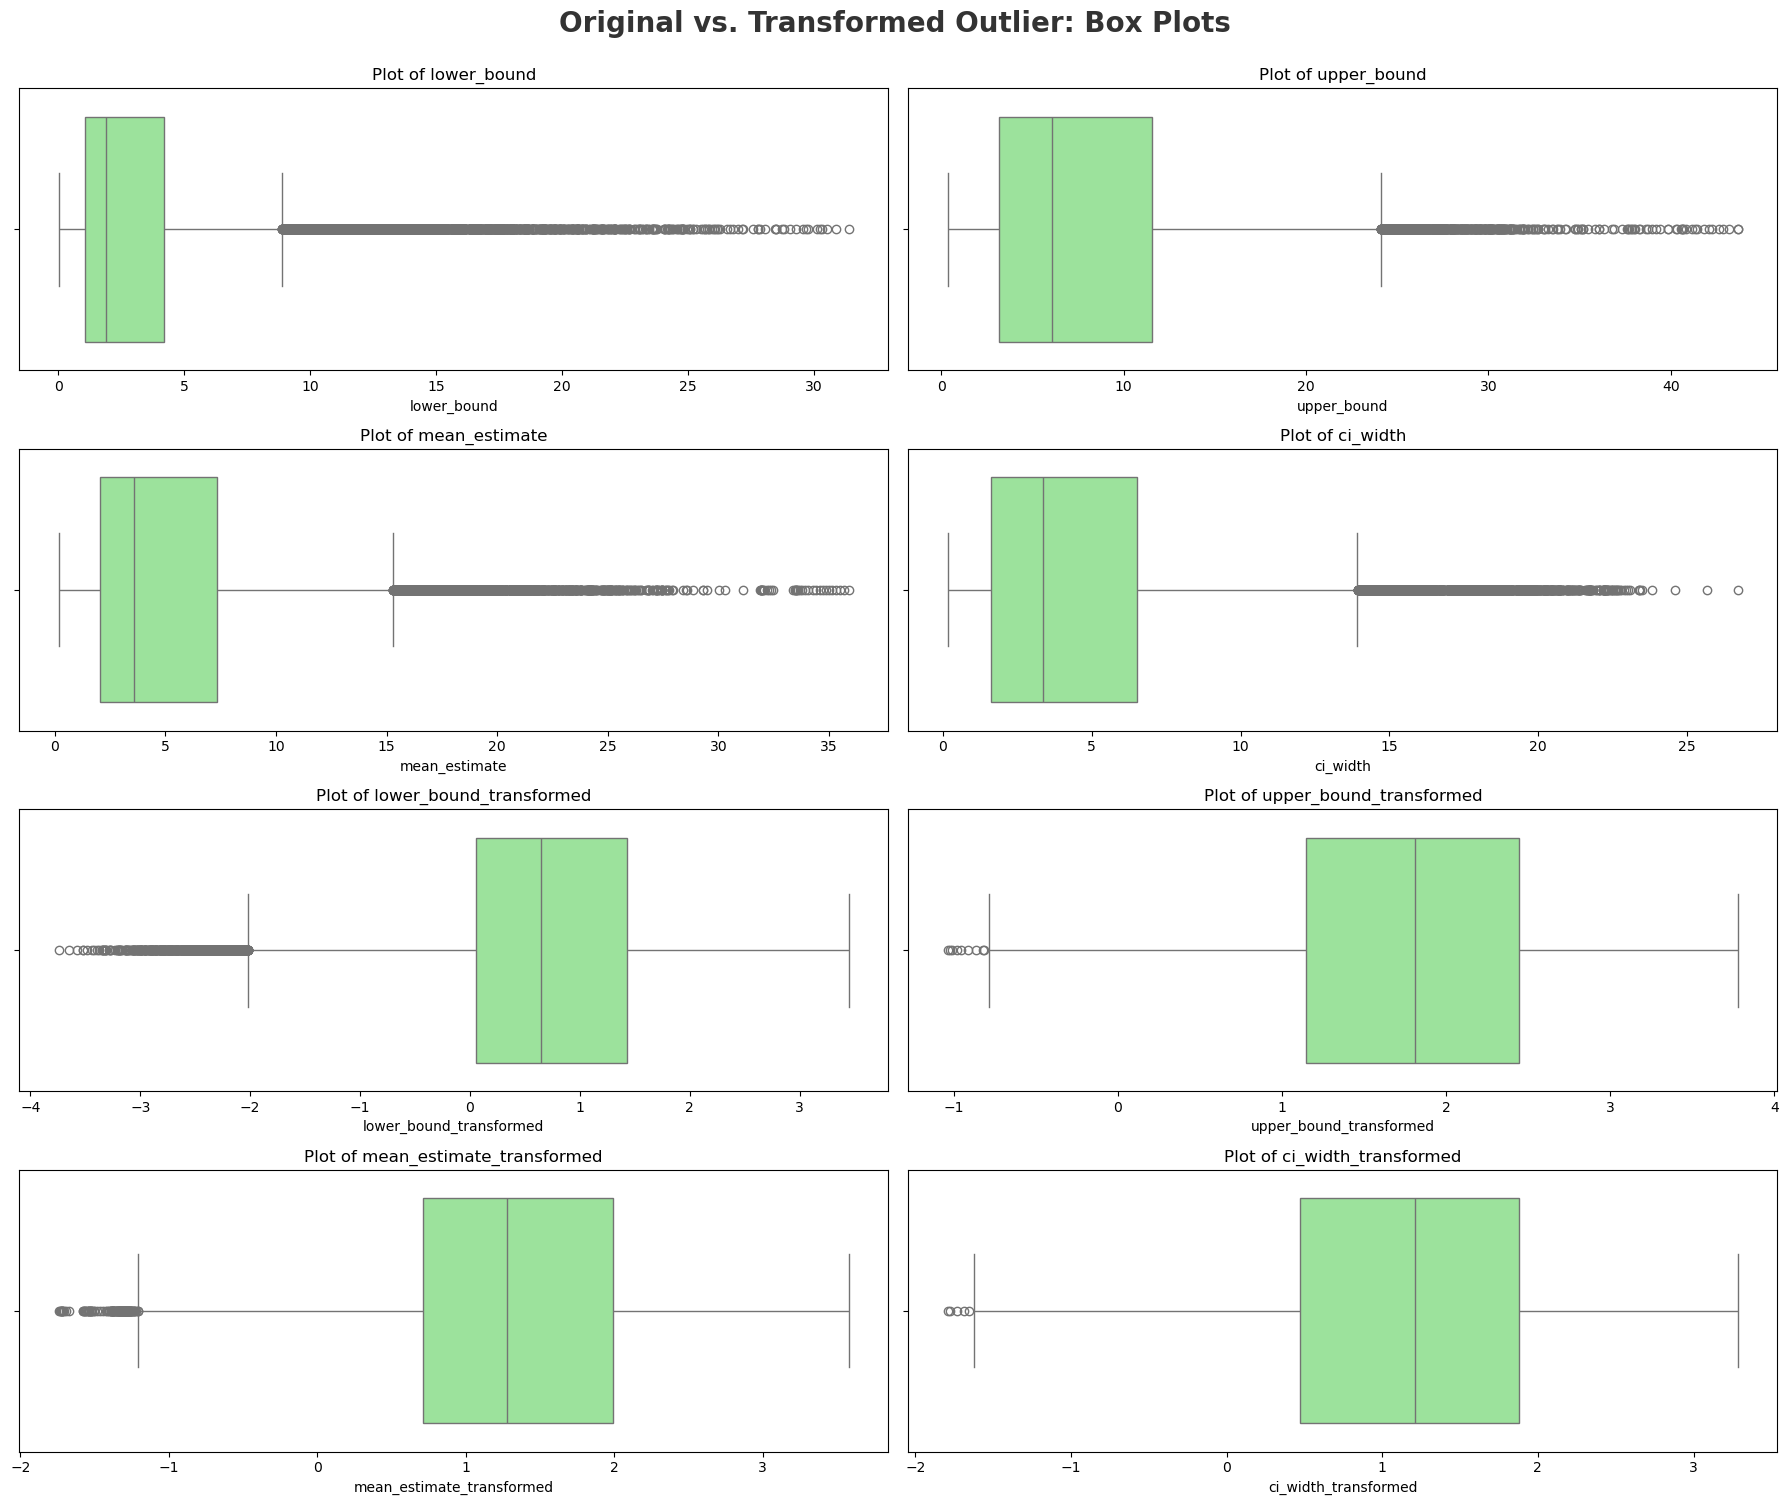

In [63]:
# Box plot of Numerical columns to outliers
numeric_features_transformed = ['lower_bound','upper_bound','mean_estimate','ci_width','lower_bound_transformed','upper_bound_transformed','mean_estimate_transformed','ci_width_transformed']
plt.figure(figsize=(18, 15))
plt.suptitle('Original vs. Transformed Outlier: Box Plots', fontsize=20, fontweight='bold', alpha=0.8, y=1.)
for i,col in enumerate(numeric_features_transformed):
    plt.subplot(4, 2, i+1)
    sns.boxplot(x=df[col], color='lightgreen')
    plt.xlabel(numeric_features_transformed[i])
    plt.title(f'Plot of {numeric_features_transformed[i]}')
plt.tight_layout()
plt.show()

In [64]:
print('Original Number of Outliers in dataset')
print(f'Number of outliers in Lower bound : {count_outliers_iqr(df['lower_bound'])}')
print(f'Number of outliers in Upper bound : {count_outliers_iqr(df['upper_bound'])}')
print(f'Number of outliers in Mean estimate : {count_outliers_iqr(df['mean_estimate'])}')
print(f'Number of outliers in CI Width : {count_outliers_iqr(df['ci_width'])}')
print('\n')
print('After Transformation Number of Outliers in dataset')
print(f'Number of outliers in Lower bound : {count_outliers_iqr(df['lower_bound_transformed'])}')
print(f'Number of outliers in Upper bound : {count_outliers_iqr(df['upper_bound_transformed'])}')
print(f'Number of outliers in Mean estimate : {count_outliers_iqr(df['mean_estimate_transformed'])}')
print(f'Number of outliers in CI Width : {count_outliers_iqr(df['ci_width_transformed'])}')

Original Number of Outliers in dataset
Number of outliers in Lower bound : 2497
Number of outliers in Upper bound : 761
Number of outliers in Mean estimate : 1509
Number of outliers in CI Width : 1314


After Transformation Number of Outliers in dataset
Number of outliers in Lower bound : 650
Number of outliers in Upper bound : 9
Number of outliers in Mean estimate : 124
Number of outliers in CI Width : 5


## Log transform applied on outlier
    After transform we have 215 outlier in lower bound , 247 outlier in upper bound, 148 outlier in mean estimate, 125 outlier in ci width which is in left side of distribution

In [66]:
# Apply log1p transformation
df['lower_bound_transformed'] = np.log1p(df['lower_bound'])
df['upper_bound_transformed'] = np.log1p(df['upper_bound'])
df['mean_estimate_transformed'] = np.log1p(df['mean_estimate'])
df['ci_width_transformed'] = np.log1p(df['ci_width'])

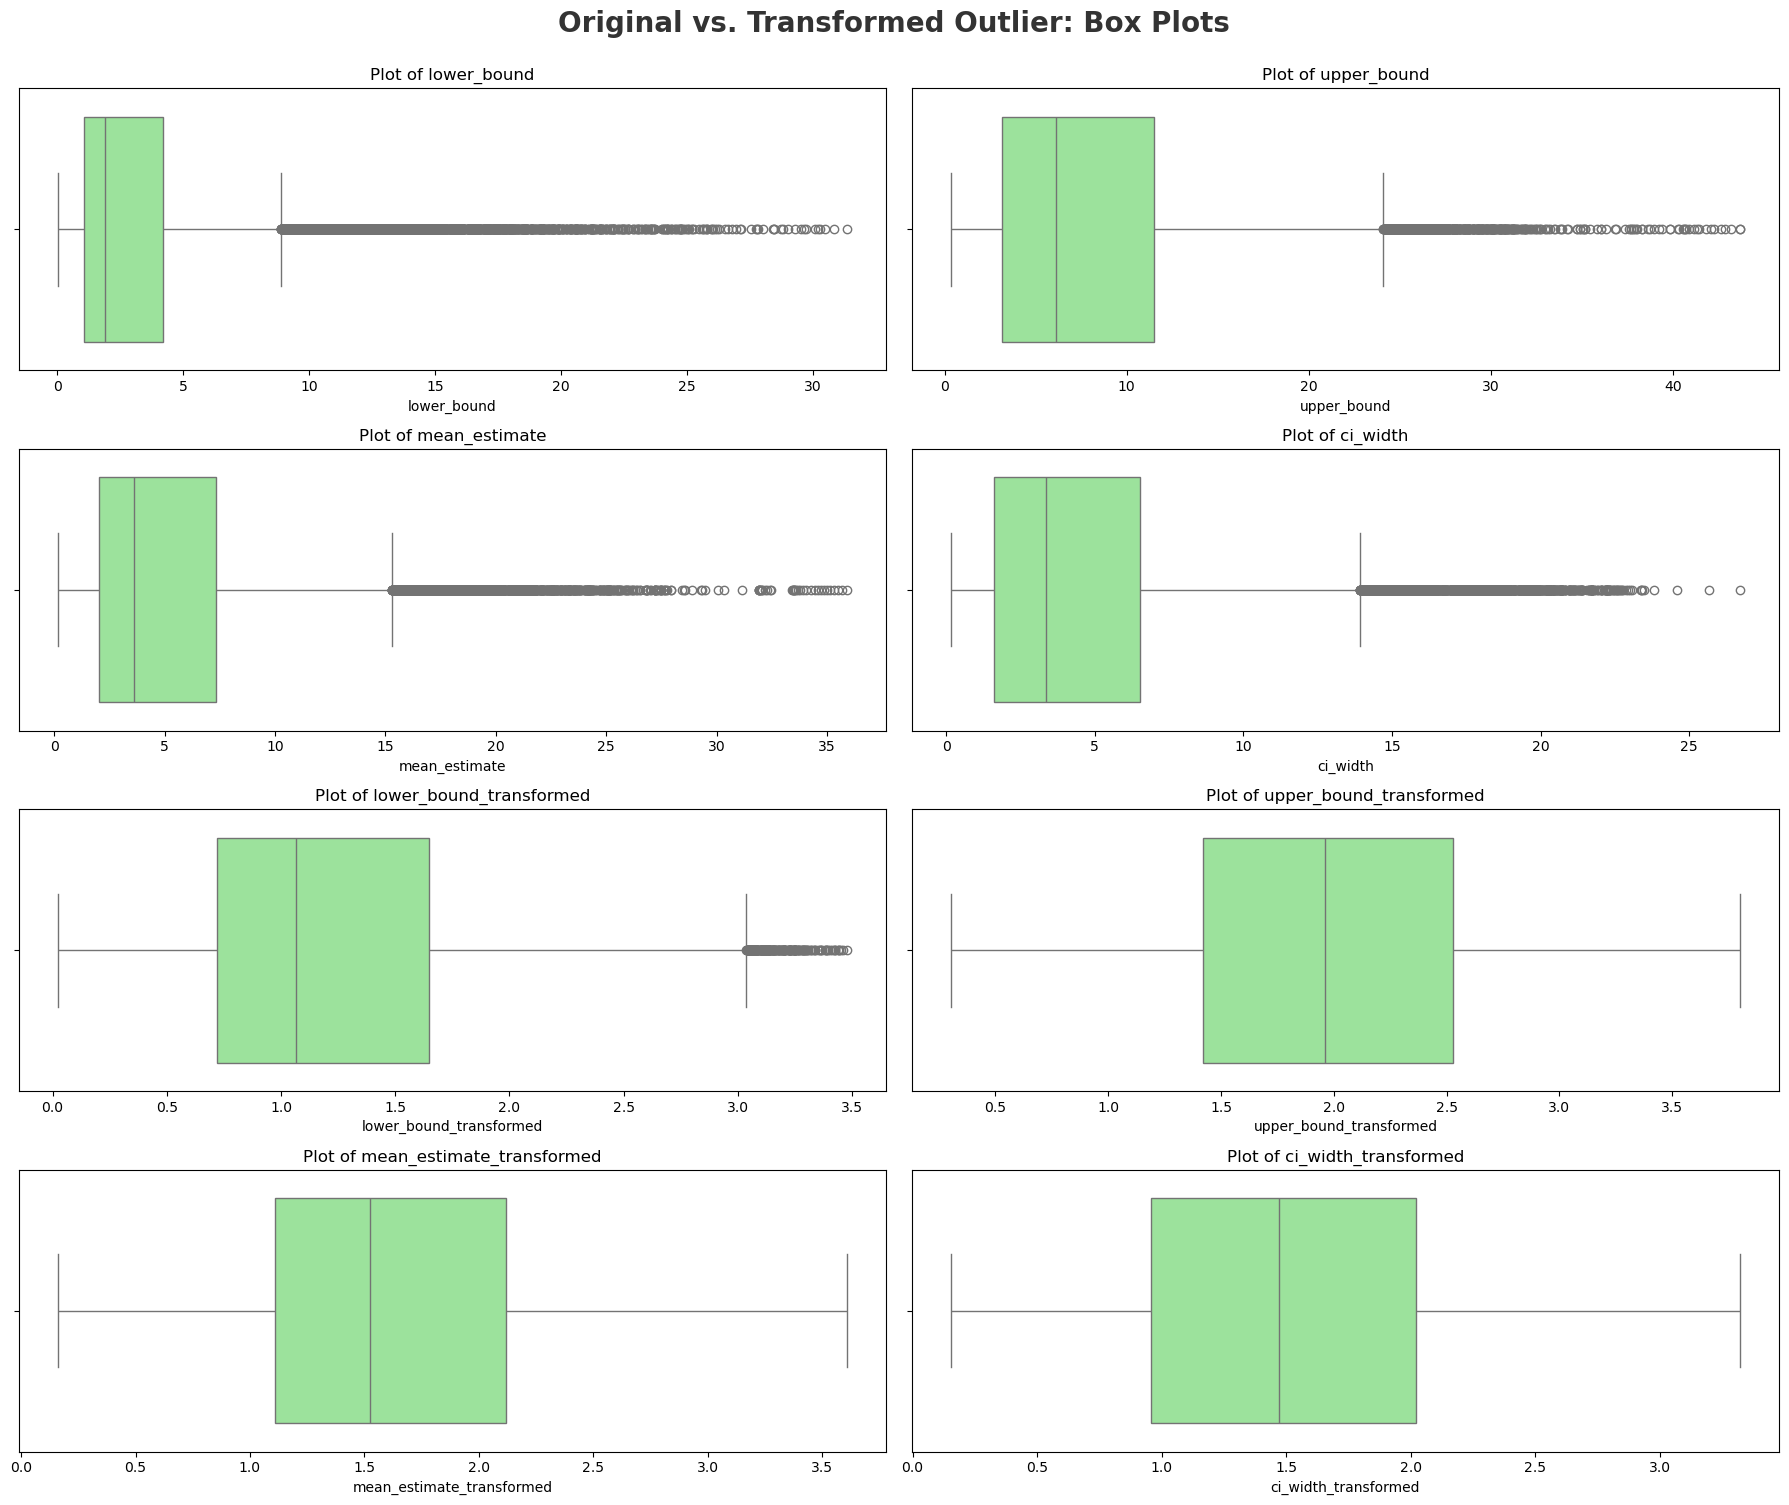

In [67]:
# Box plot of Numerical columns to outliers
numeric_features_transformed = ['lower_bound','upper_bound','mean_estimate','ci_width','lower_bound_transformed','upper_bound_transformed','mean_estimate_transformed','ci_width_transformed']
plt.figure(figsize=(18, 15))
plt.suptitle('Original vs. Transformed Outlier: Box Plots', fontsize=20, fontweight='bold', alpha=0.8, y=1.)
for i,col in enumerate(numeric_features_transformed):
    plt.subplot(4, 2, i+1)
    sns.boxplot(x=df[col], color='lightgreen')
    plt.xlabel(numeric_features_transformed[i])
    plt.title(f'Plot of {numeric_features_transformed[i]}')
plt.tight_layout()
plt.show()

In [68]:
print('Original Number of Outliers in dataset')
print(f'Number of outliers in Lower bound : {count_outliers_iqr(df['lower_bound'])}')
print(f'Number of outliers in Upper bound : {count_outliers_iqr(df['upper_bound'])}')
print(f'Number of outliers in Mean estimate : {count_outliers_iqr(df['mean_estimate'])}')
print(f'Number of outliers in CI Width : {count_outliers_iqr(df['ci_width'])}')
print('\n')
print('After Transformation Number of Outliers in dataset')
print(f'Number of outliers in Lower bound : {count_outliers_iqr(df['lower_bound_transformed'])}')
print(f'Number of outliers in Upper bound : {count_outliers_iqr(df['upper_bound_transformed'])}')
print(f'Number of outliers in Mean estimate : {count_outliers_iqr(df['mean_estimate_transformed'])}')
print(f'Number of outliers in CI Width : {count_outliers_iqr(df['ci_width_transformed'])}')

Original Number of Outliers in dataset
Number of outliers in Lower bound : 2497
Number of outliers in Upper bound : 761
Number of outliers in Mean estimate : 1509
Number of outliers in CI Width : 1314


After Transformation Number of Outliers in dataset
Number of outliers in Lower bound : 210
Number of outliers in Upper bound : 0
Number of outliers in Mean estimate : 0
Number of outliers in CI Width : 0


## Log1p transform applied on outlier
    After transform we have 0 outlier in lower bound , 0 outlier in mean estimate, 0 outlier in ci width and  35 outlier in upper bound which is in left side of the distribution

In [70]:
# Apply square root transformation
df['lower_bound_transformed'] = np.sqrt(df['lower_bound'])
df['upper_bound_transformed'] = np.sqrt(df['upper_bound'])
df['mean_estimate_transformed'] = np.sqrt(df['mean_estimate'])
df['ci_width_transformed'] = np.sqrt(df['ci_width'])

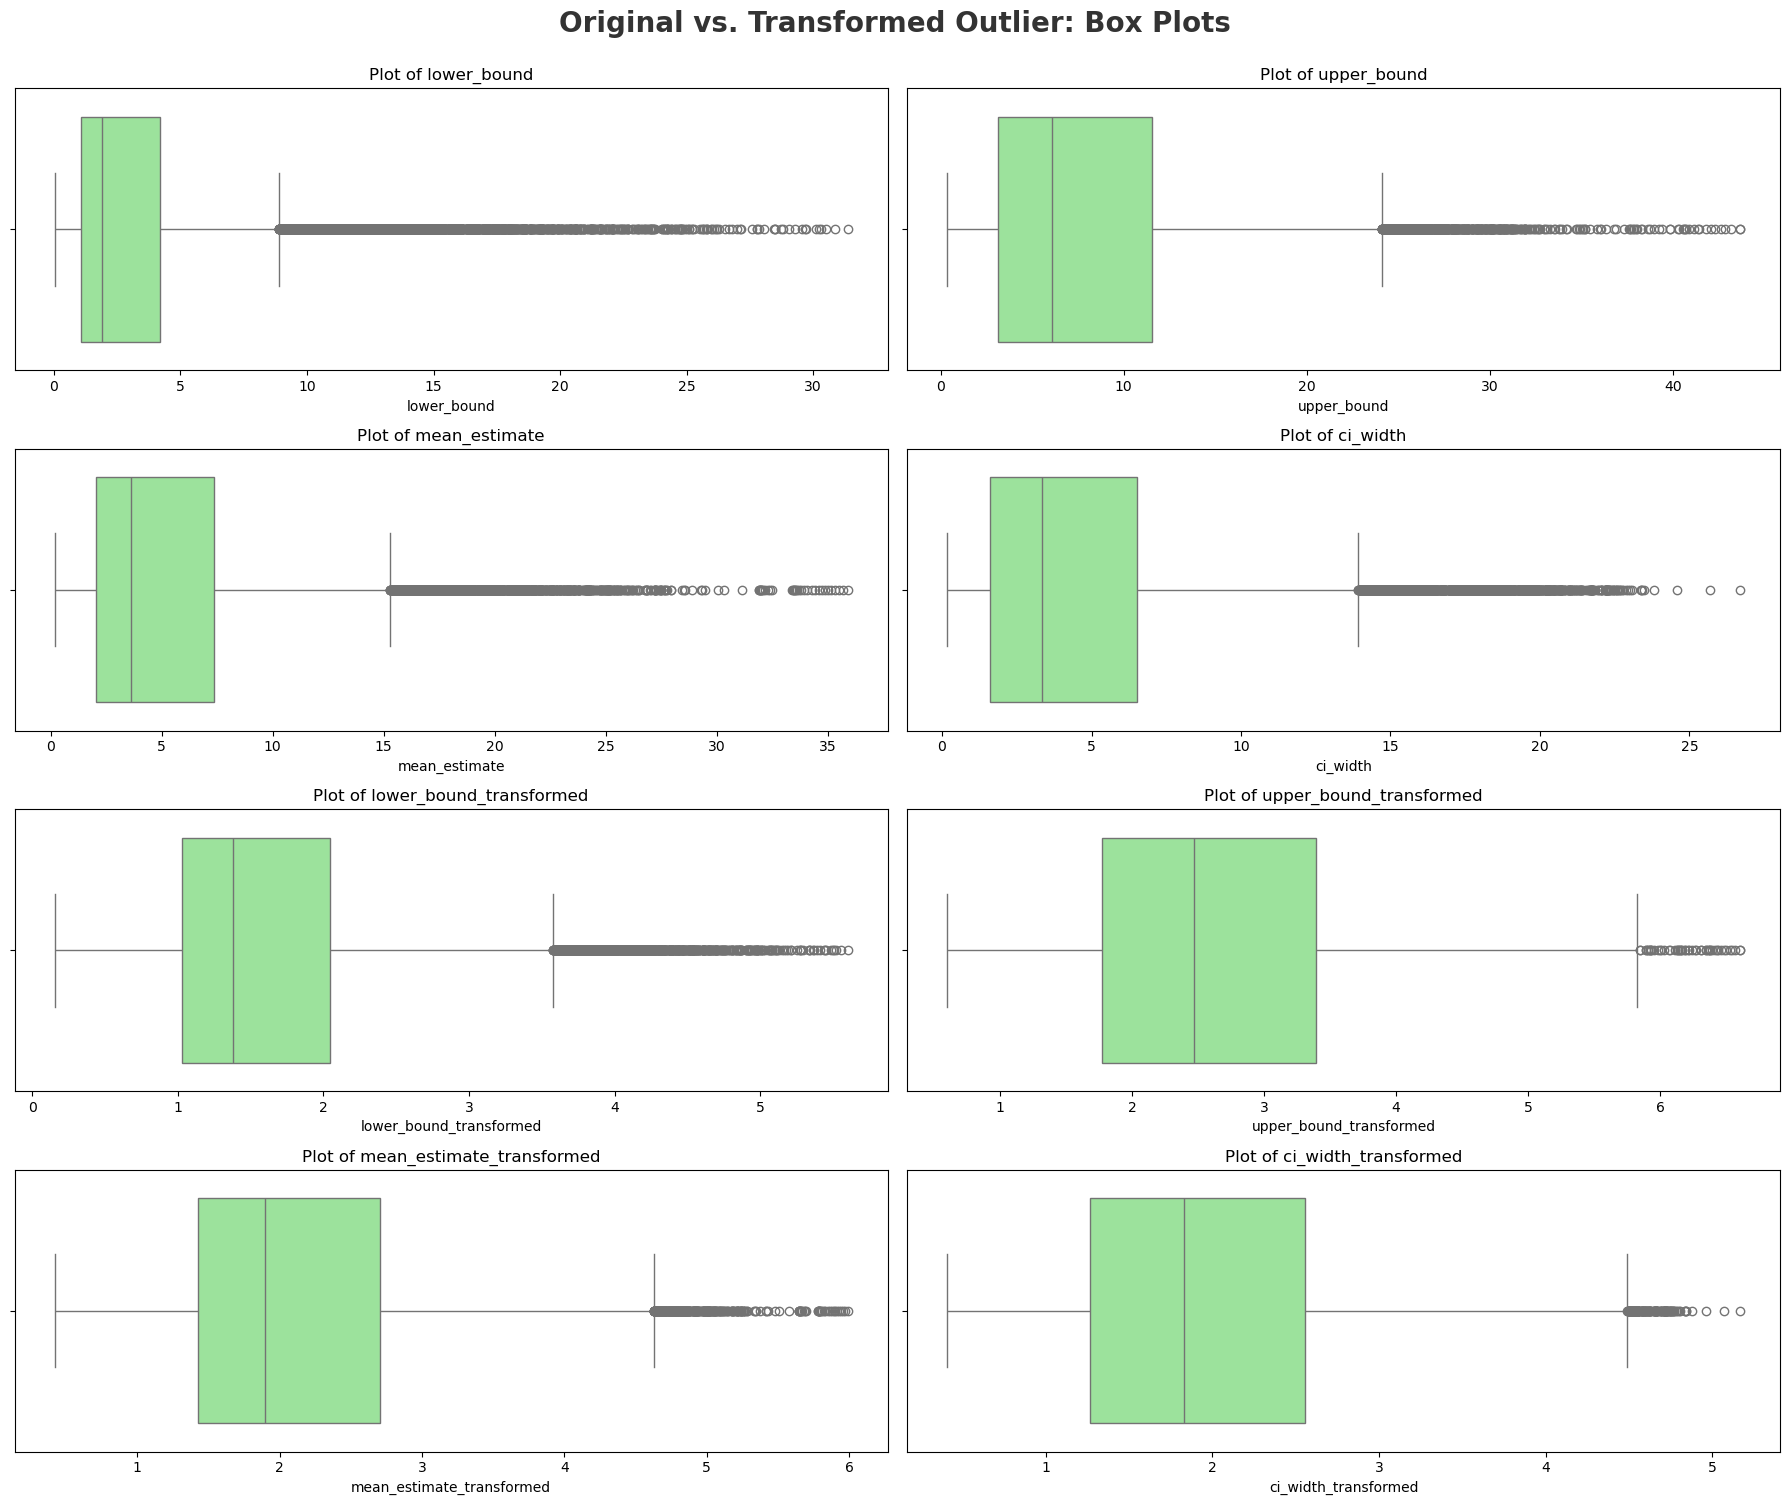

In [71]:
# Box plot of Numerical columns to outliers
numeric_features_transformed = ['lower_bound','upper_bound','mean_estimate','ci_width','lower_bound_transformed','upper_bound_transformed','mean_estimate_transformed','ci_width_transformed']
plt.figure(figsize=(18, 15))
plt.suptitle('Original vs. Transformed Outlier: Box Plots', fontsize=20, fontweight='bold', alpha=0.8, y=1.)
for i,col in enumerate(numeric_features_transformed):
    plt.subplot(4, 2, i+1)
    sns.boxplot(x=df[col], color='lightgreen')
    plt.xlabel(numeric_features_transformed[i])
    plt.title(f'Plot of {numeric_features_transformed[i]}')
plt.tight_layout()
plt.show()

In [72]:
print('Original Number of Outliers in dataset')
print(f'Number of outliers in Lower bound : {count_outliers_iqr(df['lower_bound'])}')
print(f'Number of outliers in Upper bound : {count_outliers_iqr(df['upper_bound'])}')
print(f'Number of outliers in Mean estimate : {count_outliers_iqr(df['mean_estimate'])}')
print(f'Number of outliers in CI Width : {count_outliers_iqr(df['ci_width'])}')
print('\n')
print('After Transformation Number of Outliers in dataset')
print(f'Number of outliers in Lower bound : {count_outliers_iqr(df['lower_bound_transformed'])}')
print(f'Number of outliers in Upper bound : {count_outliers_iqr(df['upper_bound_transformed'])}')
print(f'Number of outliers in Mean estimate : {count_outliers_iqr(df['mean_estimate_transformed'])}')
print(f'Number of outliers in CI Width : {count_outliers_iqr(df['ci_width_transformed'])}')

Original Number of Outliers in dataset
Number of outliers in Lower bound : 2497
Number of outliers in Upper bound : 761
Number of outliers in Mean estimate : 1509
Number of outliers in CI Width : 1314


After Transformation Number of Outliers in dataset
Number of outliers in Lower bound : 1175
Number of outliers in Upper bound : 52
Number of outliers in Mean estimate : 338
Number of outliers in CI Width : 163


## Square root transform applied on outlier
    After transform we have 321 outlier in lower bound , 216 outlier in upper bound, 287 outlier in mean estimate, 283 outlier in ci width at right side of the distribution

In [74]:
# Apply Box-Cox transformation
df['lower_bound_transformed'], lambda_ = stats.boxcox(x = df['lower_bound'])
df['upper_bound_transformed'], lambda_ = stats.boxcox(x = df['upper_bound'])
df['mean_estimate_transformed'], lambda_ = stats.boxcox(x = df['mean_estimate'])
df['ci_width_transformed'], lambda_ = stats.boxcox(x = df['ci_width'])

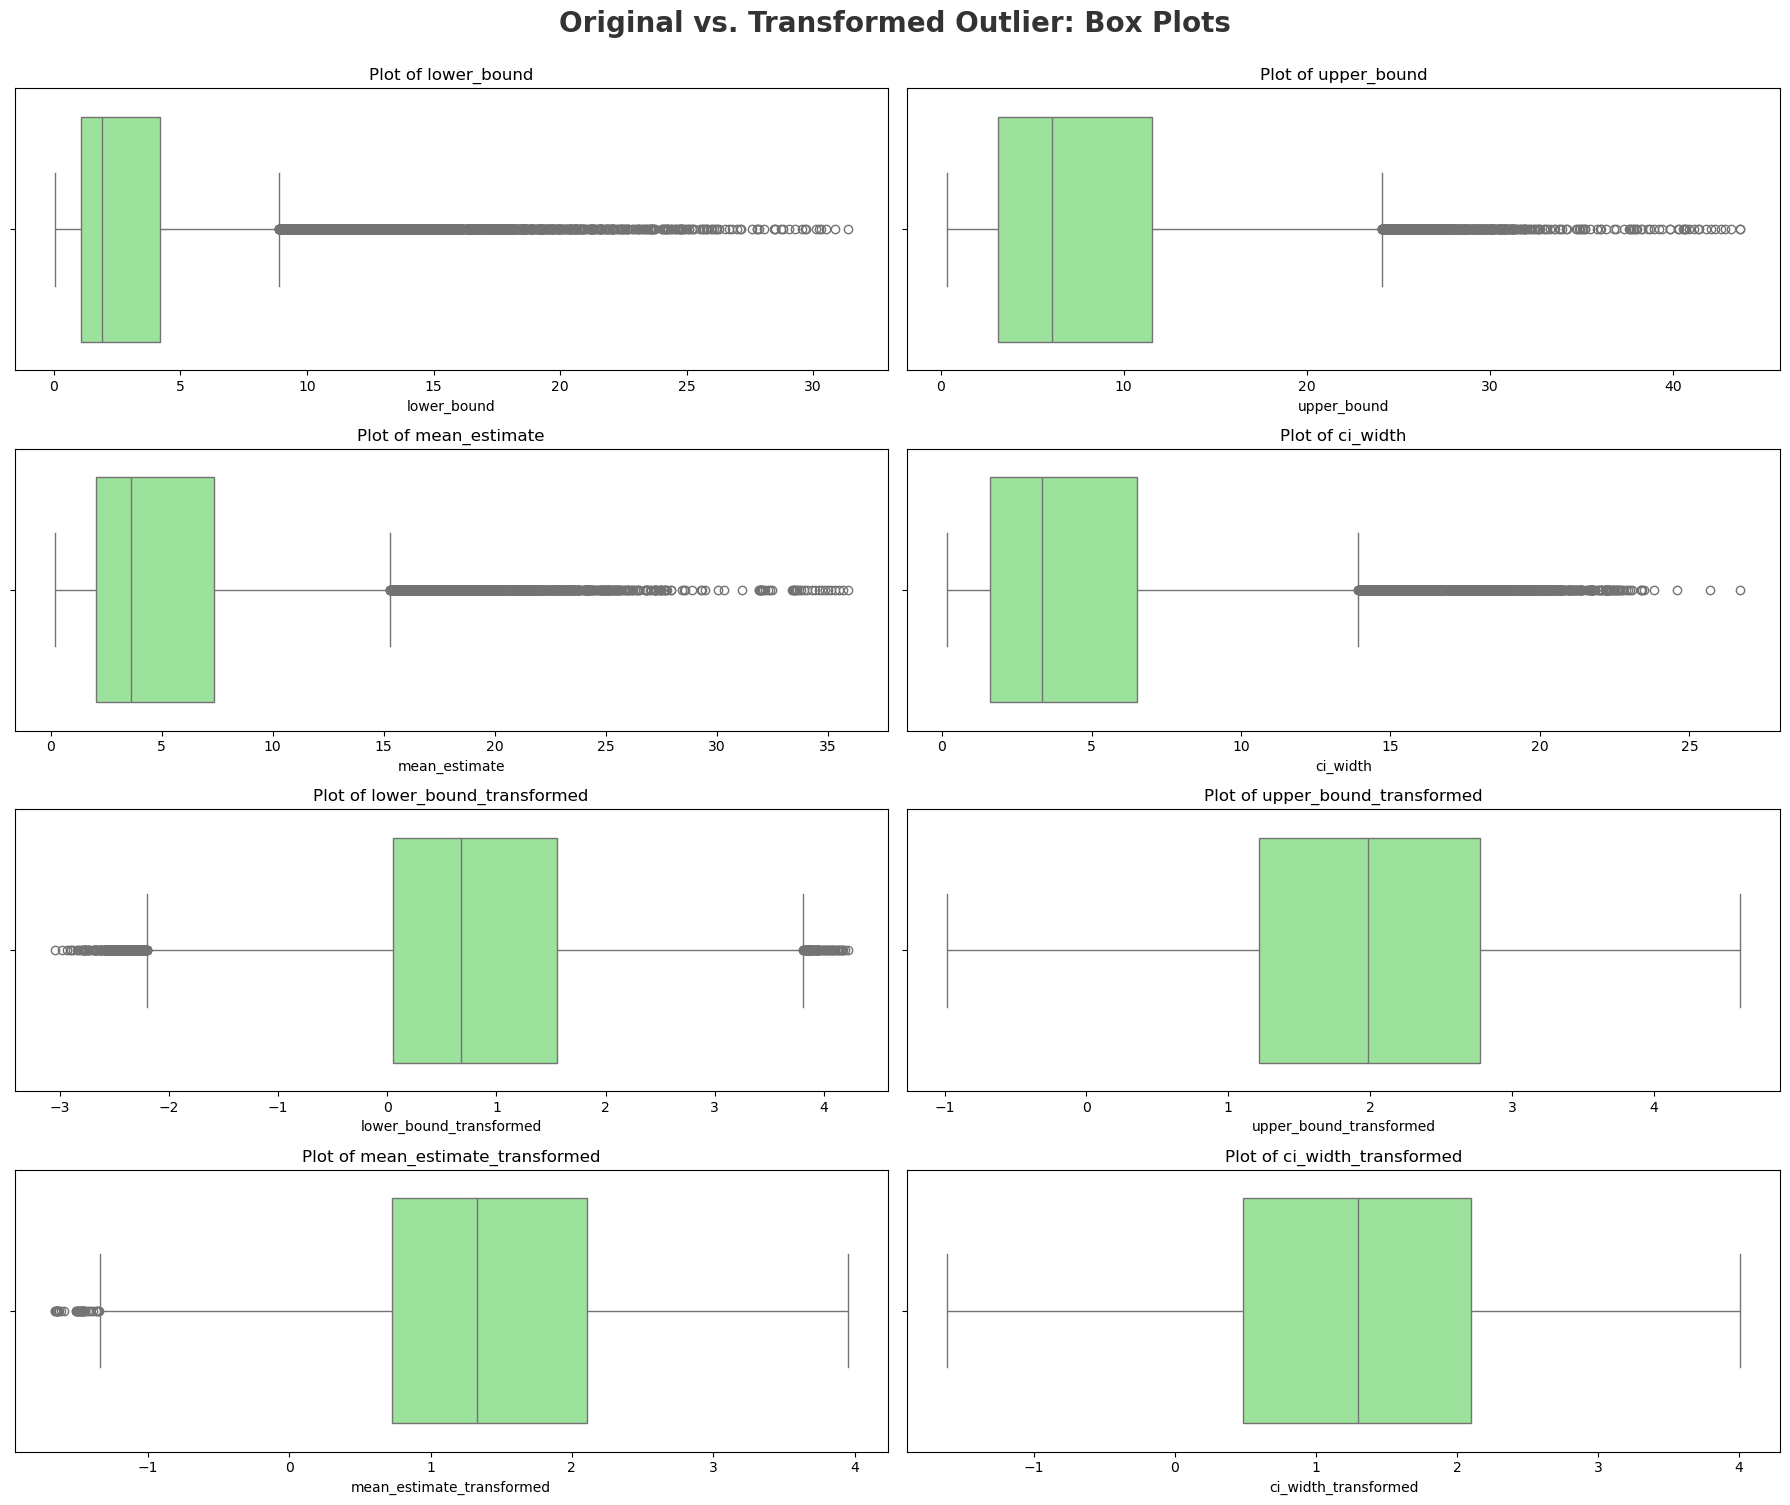

In [75]:
# Box plot of Numerical columns to outliers
numeric_features_transformed = ['lower_bound','upper_bound','mean_estimate','ci_width','lower_bound_transformed','upper_bound_transformed','mean_estimate_transformed','ci_width_transformed']
plt.figure(figsize=(18, 15))
plt.suptitle('Original vs. Transformed Outlier: Box Plots', fontsize=20, fontweight='bold', alpha=0.8, y=1.)
for i,col in enumerate(numeric_features_transformed):
    plt.subplot(4, 2, i+1)
    sns.boxplot(x=df[col],color='lightgreen')
    plt.xlabel(numeric_features_transformed[i])
    plt.title(f'Plot of {numeric_features_transformed[i]}')
plt.tight_layout()
plt.show()

In [76]:
print('Original Number of Outliers in dataset')
print(f'Number of outliers in Lower bound : {count_outliers_iqr(df['lower_bound'])}')
print(f'Number of outliers in Upper bound : {count_outliers_iqr(df['upper_bound'])}')
print(f'Number of outliers in Mean estimate : {count_outliers_iqr(df['mean_estimate'])}')
print(f'Number of outliers in CI Width : {count_outliers_iqr(df['ci_width'])}')
print('\n')
print('After Transformation Number of Outliers in dataset')
print(f'Number of outliers in Lower bound : {count_outliers_iqr(df['lower_bound_transformed'])}')
print(f'Number of outliers in Upper bound : {count_outliers_iqr(df['upper_bound_transformed'])}')
print(f'Number of outliers in Mean estimate : {count_outliers_iqr(df['mean_estimate_transformed'])}')
print(f'Number of outliers in CI Width : {count_outliers_iqr(df['ci_width_transformed'])}')

Original Number of Outliers in dataset
Number of outliers in Lower bound : 2497
Number of outliers in Upper bound : 761
Number of outliers in Mean estimate : 1509
Number of outliers in CI Width : 1314


After Transformation Number of Outliers in dataset
Number of outliers in Lower bound : 330
Number of outliers in Upper bound : 0
Number of outliers in Mean estimate : 37
Number of outliers in CI Width : 0


## Box-cox transform applied on outlier
    After transform we have 4 outlier in lower bound , 10 outlier in upper bound, 13 outlier in mean estimate, 9 outlier in ci width

## Observation from the four transformation
    Comparing all the outlier transformation we get least number of outlier in log1p transfomation, So it is best transformation for this dataset to reduce the outliers and get the distribution reduced